## Prediction of Flight Delays in the United States using Machine Learning Algorithms at Scale

MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Spring 2022

Team 25: Weston, Spencer T., Malavé, Michael, Laface, Stephanie M., Tertzakian, Andy

## Table of Contents: 
1. Phases  Summaries
2. Introduction and Context
3. Question Formulation
4. EDA & Discussion of Challenges
5. Feature Engineering
6. Algorithm Exploration
7. Algorithm Implementation & Evaluation
8. Conclusions
9. Application of Course Concepts

## 1. Phase Summaries

Phase I: Our work was split into two main categories: EDA and research. The EDA process involves checking for null values, identifying possible keys for joining tables, and developing a understanding of the data dictionaries. We are also working to setup storage for intermediate products to avoid recomputing expensive tasks. On the research side, we've identified several interesting features from other studies that we plan to incorporate into our project. One example is aggregating recent delayed flights as prior delays appear predictive of future delays. Finally, we researched cross-validation strategies for model selection on time series data and decided upon a rolling basis cross validation methodology which we identified in the literature

Phase II: We faced challenges with writing time to blob storage. We continued to exlore the Weather EDA set to ensure we obtained appropirate features. The datasets were joined. For the Rolling Basis Cross Validation strategy we finalized the spliting of the data into train/validation/test sets.

Phase III: We continued to investigate null values in our explanatory variables. Our pipeline became efficient allowing us to more quickly explore feature engineering techniques. Our cross-validation strategy was finalized by balancing our sampling classes and then implementing the customized cross validation function. We ran a baseline model with logistic regression and obtained evaluation metrics of Accuracy: 0.81 and Precision 0.76.

Phase IV: We selected our several algorithims to add to testing including the random forest and multilayer perceptron. We also implemented PageRank based on the destination airport, adding a whole new feature to our data. In terms of performance, the initial pipeline became efficient, we still discovered downstream performance issues while performing many evaluations and not writing enough. 

Phase V: While we had our models chosen, we worked on standardizing our evaluations and formalizing our documentation. We also finalized our conclusions and prepared to deliver our Presentation.

## 2. Introduction and Context

Every day, thousands of flights are flown over the United States. As a result of technical issues, logistical backlogs with passengers, weather delays, air traffic congestion, etc. a non-insignicant proportion of these flights are delayed. These delays cause inconveniences to passangers, losses for businesses, and headaches in general. It is estimated that almost 70% of all flights that are delayed are a result of weather related issues. [[1]](https://www.faa.gov/nextgen/programs/weather/faq/)

![flight_delays](https://www.faa.gov/nextgen/programs/weather/images/delay.jpg)

As a credit card company, it is important to us that our clients who are flying while using our credit cards with partnerships airlines are as pleased with their flying experience. In unfortunate circumstances when there are unexpected delays to a customer's flight, a customer's flying experience might be negatively impacted. In an effort to mitigate these negative customer experiences, we seek to predict if a flight will be delayed. In the case they are, we will be piloting a program where we provide our affected customers with a meal voucher relative to the size of the delay. To that end, we will be looking to incorporate weather data with past flight information to determine if and when a future flight will be delayed.

If successful, we expect to increase the both the lifetime value of our customers by increasing customer loyalty and their card usage.

## 3. Question Formulation
For our credit card company's business case, our team's goal is to predict the depature delay 2 hours ahead of scheduled depature time. This will enable the company to offer meal vouchers to customers subject to flight delays on US state airports. To determine which customers should receive this offer, we need to predict when and where flight delays will occur.

We use a flight dataset from the `Bureau of Transportation Statistics`[2] and a weather dataset from the `National Oceanic and Atmospheric Administration Repository (NOAA)`[3]. 

We will attempt to predict both rather a flight is delayed and how long the flight is delayed. 
The binary models will be evaluated with the standard metrics Precision and F-1 Score. The continuous model will be evaluated using Root Mean Squared Error (RMSE) and  \\(R ^2\\), and  *Adjusted* \\(R^2\\)

## 4. EDA & Discussion of Challenges:

Before beginning our pipeline and model building we conducted Exploratory Data Analysis (EDA) to better understand how we should treat the data. Some of the key issues and topics that we discovered in this EDA process were:

- Duplicate & Missing Data 
- Unbalanced dataset
- Descriptive Statistics


#### Data Transformation: Process and Join Weather Data and Flight Data

<div>
Efficient data processing was a major challenge with such a large dataset. To increase iterations and decrease time between testing, we quickly found that our process of holding off on performing writes made things more difficult. Since we found we could read some millions of rows in seconds, we developed on a process of checkpointing between each major section in the pipeline. With this in mind, as we see in the image, we moved to a model where, if we don’t need to reprocess, we only need read to the data as shown by the dotted lines.  
</div>
<img src="https://static.wixstatic.com/media/3ea3ff_68ca894d8015480395a22e248872519b~mv2.png/v1/fill/w_740,h_331,al_c,q_90/3ea3ff_68ca894d8015480395a22e248872519b~mv2.webp" width=35%>

<div>
Strategic filtering was also key to iterations. Weather data and stations data contain a superset of locations. Because our focus is only data related to our flights, a subset, we can get and format that data first, then filter the stations and then weather data for those locations. This would allow filtering to be dynamic and based on the data we are using. As we handle each dataset, we will be reading them to memory (often with a filter), processing columns to fit needs, filtering data again, and finally joining the data. After each phase, we write the results to the disk to be read. </div>
<img src="https://static.wixstatic.com/media/3ea3ff_cec1203373ca4661b45ee66a21afc661~mv2.png/v1/fill/w_740,h_589,al_c,q_90/3ea3ff_cec1203373ca4661b45ee66a21afc661~mv2.webp" width=25%>

#### Feature engineering: 
- Page Rank Evaluation 
- One hot encoding
- Principal Component Analysis
- Operationalize and Prevent Data Leakage

#### Split the data into train/test set for ML pipeline
- Split by `YEAR`
- Cross Validation on a Rolling Basis Application

#### Duplicate data

We found that the airlines dataset had over 63 million rows where many were duplicates. Dropping these duplicates in our pipeline within the `write_process_airlines` helper function allowed us to refine to a dataset where we keep only what we need to use. The final row count for airlines de-duplicated dataset was approximately 32 million rows.

In [0]:
%run ./helper_functions

In [0]:
%run ./Feature_Engineering

In [0]:
# Original dataset row count
df_airlines = spark.read.parquet("/mnt/mids-w261/datasets_final_project/parquet_airlines_data/*").cache()
airline_row_org = df_airlines.count()
print("Original row count", airline_row_org)
 
# Identify duplicates in airlines dataset
distinctDF = df_airlines.distinct()
print("Distinct count: "+str(distinctDF.count()))
 
# Drop duplicate rows identified in airlines dataset
df_airlines = df_airlines.dropDuplicates()
row = df_airlines.count()
print("De-duplicated row count", row)

Original row count 63493682
Distinct count: 31746841
De-duplicated row count 31746841

##### Missing Data & Removed Data
For flight performance data we observed that there were columns that had a high number of missing values. We learned that where many were null with respect to airlines data, those rows were in fact cancellations and not directly part of what we wanted to learn. In this case, we decided to ignore this within our data and focus on a binary decision of being delayed greater than 15 minutes or not. In the weather data, we found that many values were only filled when there was a change. To remediate this, we filled forward the data to ensure we had the values we needed for the relevant times and dates. 

Moreover, in our processing of the data, multiple columns were determined to be outcome variables and to be known only after the fact. As a result, we removed them to reduce the chance that data leakage might occur to the outcome variable of the flight departure being delayed. Within our airlines data, the following fit that criteria:
`'DEP_DELAY', 'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',` `'LATE_AIRCRAFT_DELAY', 'FIRST_DEP_TIME', 'DIV_ARR_DELAY', 'DEP_DELAY_GROUP'`

Your new df_flights_weather has 182,370 rows.

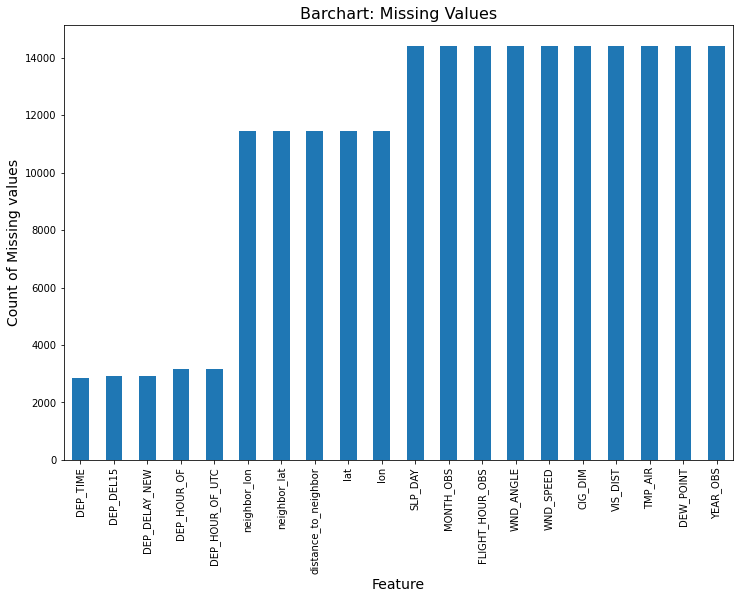

In [0]:
flights_weather_data_dev = process_pipeline(env='dev', write=False)
flights_weather_data_df = flights_weather_data_dev.toPandas()
import matplotlib.pyplot as plt
missing_cols = flights_weather_data_df.isnull().sum()
plot_cols = missing_cols[missing_cols>1000] # drop 0 count cols
plot_cols.sort_values(inplace=True)
plot_cols.plot.bar(figsize=(12,8))
plt.xlabel("Feature",fontsize=14)
plt.ylabel("Count of Missing values",fontsize=14)
plt.title("Barchart: Missing Values",fontsize=16)
plt.show()

### Class Imbalance for Departure Delays
The histogram below displays the `DEP_DELAY_GROUP` field which groups delay times by 15 minute intervals by code. This distribution is skewed to the right as the majority of flights are delayed less than 15 minutes as shown prior to bucket `1` for `DEP_DELAY_GROUP` which is the `Delay between 15 to 29 minutes`.

Out[73]:

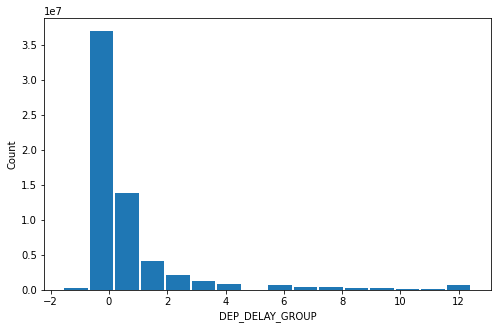

Text(0, 0.5, 'Count')

In [0]:
n_buckets = len(df_airlines.select("DEP_DELAY_GROUP").distinct().collect())
hist = df_airlines.select("DEP_DELAY_GROUP").rdd.flatMap(lambda x: x).histogram(n_buckets)
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x=hist[0][1:], height=hist[1])
ax.set_xlabel('DEP_DELAY_GROUP')
ax.set_ylabel('Count')

#### Descriptive Statistics

We investigated descriptive statistics on columns concering time measurements and delays. We found the average delay in departure and arrival was 12 minutes. This validates our outcome variable `DEP_DEl15` where any flight with delay > 15 minutes is regarded as delayed. We also noted that `Late Aircraft Delay` and `Carrier Delay` reasons have the highest average delay in minutes when compared to other delay reasons.

In [0]:
df_airlines.select(['DEP_DELAY_NEW', 'ARR_DELAY_NEW','TAXI_OUT', 'AIR_TIME', 'ACTUAL_ELAPSED_TIME', 'DISTANCE','CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY']).describe().toPandas()

Out[1667]:

,summary,DEP_DELAY_NEW,ARR_DELAY_NEW,TAXI_OUT,AIR_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,count,31269545,31176201,31260424,31178799,31178799,31746841,5799114,5799114,5799114,5799114,5799114
1,mean,12.909587811399238,12.966188215170925,16.830789563186986,113.8502422431345,138.22906985609035,823.2170183483768,19.98459350859459,3.2259498606166392,15.44036813209742,0.08916793151505557,25.364284785572416
2,stddev,42.44165318434853,42.14088584758868,9.488981863443772,72.24024903973574,74.33716296557809,607.6826683052017,59.30797970625767,26.81202538233582,34.739082338772576,2.9147981743398175,48.60358147038258
3,min,0.0,0.0,0.0,4.0,14.0,21.0,0.0,0.0,0.0,0.0,0.0
4,max,2755.0,2695.0,227.0,1557.0,1604.0,5095.0,2695.0,2692.0,1848.0,1078.0,2454.0


####  Data Transformation: Process and Join Data

Before we can begin our feature engineering and model building, we first join our datasets for flights and weather together. This process is accomplished through our `process_pipeline` helper function which triggers the following steps. Overall, this pipeline implementation takes approximately 2 hours to execute with a 2.9 minute final join.

       1. Retrieves the airline data, which includes converting hour of day to UTC time for future joining
       2. Gets the list of distinct airports
       3. Retrieves the the weather station data
       4. Aggregates the weather station data down to minimize its size by picking the station which is closest to the airport in question
       5. Joins the airline data with station list by location
       6. Retrieves the weather data
       7. Aggregates the weather data down to the hour of the day
       8. Finally, join the weather data to the station-airline data on location and hour

In [0]:
# Set if this should be run on dev or prod
STAGE = 'prod' # 'dev'/'prod'

# Set if the pipeline stages should be written to storage
write_flag = False

# Define label columns (categorical and continuous)
label_cat = 'DEP_DEL15'
label_cont = 'DEP_DELAY_NEW'
flights_weather_data = process_pipeline(env=STAGE, write=write_flag)

Your new df_flights_weather has 31,746,841 rows.

In [0]:
flights_weather_data = spark.read.parquet(f"{blob_url}/feature-engineering/flight_weather_pagerank_historical")
flights_weather_data = flights_weather_data.drop('pagerank', 'historical_pagerank', 'hist_pr_id').cache()

## 5. Feature Engineering

After the join, we perform feature engineering to create our supervised learning set. The feature engineering pipeline has three steps. First, we employ the PageRank algorithm to estimate the steady state vector of inbound delays. Second, standard data transformations are applied such as one hot encoding for categorical variables, imputation of null values, and scaling of data. Finally, due to the increase in features from the one hot encoding, Principal Component Analysis is applied to create a smaller feature set.

### PageRank
#### PageRank Algorithm for Flights

PageRank was originally employed as a method to utilize the graph structure of the internet, where websites are vertices and hyperlinks between sites are edges, to rank websites. PageRank calculates the steady state vector of the graph. In context of the internet, this steady state vector is a probability distribution of the likelihood that a "random surfer" randomly clicking on links will arrive at a particular web page. We apply PageRank in the context of airports where each airport is a vertex and each flight between airports is an edge. We generate a graph based on outbound delayed flights such that PageRank's steady state vector indicates the probability that a random delayed flight will be destined for a particular airport. We hypothesize this feature will help predict flight delays by capturing the propogation of delays across airports.

Let \\(a\\) indicate an airport \\(A\\) be a matrix where each element indicates the percent of delayed flights from source  airport \\(a_j\\) that fly to destion airport \\(a_i\\) over some time period \\(t\\). This is a stochastic matrix where each element indicates the percentage of delayed flights from airport \\(a_j\\) that depart for airport \\(a_i\\). When we compute page rank on this matrix, \\(PR(A)\\), the resultant steady state vector estimates the probability that a random delayed flight in the network is destined for airport \\(a_i\\).

We use the steady state vector as a feature. However, we also use the steady state probability distribution as an estimator of inbound by delays by multiplying the number of delayed flights in the network by the steady state vector. Let \\(a_{idt}\\) be the number of delayed flights from an airport at time \\(t\\). The total number of delayed flights in the network can be calculated as 

\\(N_t  = \sum_{i}^n a_{idt} \\).

where \\(N_t\\) is the estimated total number of delayed flights over some time period. Then, \\(N_t \cdot PR(A) \\) becomes the estimated number of delayed inbound flights for each airport \\(a_i\\) over time \\(t\\).

#### Example Implementation

The algorithm described above is appplied to a three airport toy dataset for illustrative purposes. Here, we drop the time subscript and assume all flights occur contemperaneously. 

* \\(a_1\\) has 30 flights. 15 of these flights are delayed. 10 of those delays are destined for \\(a_2\\) and 5 are destined for \\(a_3\\). \\(a_{1d}\\) is 15.

* \\(a_2\\) has 40 flights. 10 of these flights are delayed. 2 of those delays are destined for \\(a_1\\) and 8 are destined for \\(a_3\\). \\(a_{2d}\\) is 10.

* \\(a_3\\) has 20 flights. 5 of these flights are delayed. 3 of those delays are destined for \\(a_1\\) and 2 are destined for \\(a_2\\). \\(a_{3d}\\) is 10.

This specification generates the stochastic matrix,

\\(A = \begin{pmatrix}0 & 0.2 & 0.6 \\\ 0.666 & 0 & 0.4 \\\ 0.333 & 0.8 & 0 \end{pmatrix} \\)

with PageRank, 

\\( PR(A) \approx \begin{pmatrix} 0.289 \\\ 0.341 \\\ 0.370 \end{pmatrix} \\).

Compute the number of delays in the network as \\(N  = \sum_{i}^n a_{idt} = 30\\). Our estimate of the number of inbound delays for each airport is then defined,

\\( N \cdot PR(A) = \begin{pmatrix} 8.69 \\\ 10.23 \\\ 11.10 \end{pmatrix} \\).

However, we introduce error by using the PageRank probability distribution when the true number of inbound delays is known for the given time period. When we compute \\(N_t\\) on the flights dataset, we compute \\(N_t\\) as a function of data gathered at time \\(t-1\\).

#### Operationalize and Prevent Data Leakage

PageRank is performed on each month for each year in the dataset (2015-2019) to create 60 models. We generate models for each month to allow the use of historical models for current flights to prevent data leakage. Graph vertices are generated from all origin and destination airports with a flight record for the given month. Graph edges consist of all delayed flights between airports. The stochastic matrix is generated by dividing the number of delayed flights from \\(a_j\\) to \\(a_i\\) by the total number of delayed flights from \\(a_j\\). GraphFrames is used to transform the stochastic matrix into a graph structure, and GraphFrames' PageRank function is used to compute the PageRank. GraphFrames' PageRank output is a normed vector where each element's value is relative to the average. To create a probability vector from the GraphFrames output, each element of GraphFrames' PageRank vector is divided by the sum of the vector. This de-normed vector is then joined to the flights data.

In [0]:
# Pagerank cell 
data = read_joined_flights_weather(env='prod')
pagerank(data=data, time_period="MONTH")

In [0]:
STAGE='prod'
df_flights_weather = read_joined_flights_weather(env=STAGE)
pagerank_folder = f"{blob_url}/pagerank-month/*"
join_pagerank(df_flights_weather, pagerank_folder)
df_flights_weather.unpersist()

join.count()=31746841

For estimating the number of inbound delays for each airport, we use pagerank values computed on prior data which we refer to as historic PageRank. We've separate methods for selecting historical pagerank models for 2015 and 2016-2019. This difference is necessary since we do not have 2014 data to train PageRank on for 2015. For 2015, each month's historical PageRank is computed from the prior month such that each flight's February 2015 historical PageRank equals its January 2015 PageRank. For 2016-2019, each month's historical PageRank is determined by the same month in the prior year. For example, all flights in September 2017 will be assigned historical PageRank values from the September 2016 model.

In [0]:
df = spark.read.parquet(f"{blob_url}/feature-engineering/flight_weather_pagerank")
compute_past_pagerank(flights_weather_pagerank=df)
df.unpersist()

Iteration 0 finished for 2015-1
Iteration 1 finished for 2015-2
Iteration 2 finished for 2015-3
Iteration 3 finished for 2015-4
Iteration 4 finished for 2015-5
Iteration 5 finished for 2015-6
Iteration 6 finished for 2015-7
Iteration 7 finished for 2015-8
Iteration 8 finished for 2015-9
Iteration 9 finished for 2015-10
Iteration 10 finished for 2015-11
Iteration 11 finished for 2015-12
Iteration 12 finished for 2016
Iteration 13 finished for 2017
Iteration 14 finished for 2018
Iteration 15 finished for 2019

After this process, there are 188113 rows with null historical PageRank values which is 6 out every 1000 flights. These occur when a flight for the current time period has an origin or destination airport not present in the prior time period. Null historical PageRank values are filled with the minimum PageRank value from 2015.

In [0]:
df = spark.read.parquet(f"{blob_url}/feature-engineering/flight_weather_pagerank_historical")
fill_pagerank_na(df)
df.unpersist()

Out[897]: DataFrame[QUARTER: int, MONTH: int, DAY_OF_MONTH: int, DAY_OF_WEEK: int, OP_CARRIER_AIRLINE_ID: int, OP_CARRIER_FL_NUM: int, ORIGIN_AIRPORT_ID: int, ORIGIN_AIRPORT_SEQ_ID: int, ORIGIN_WAC: int, DEST_AIRPORT_ID: int, DEST_AIRPORT_SEQ_ID: int, DEST_STATE_FIPS: int, DEST_WAC: int, DEP_TIME: int, DEP_DEL15: double, DEP_DELAY_NEW: double, FLIGHTS: double, DISTANCE: double, DISTANCE_GROUP: int, DIV_AIRPORT_LANDINGS: int, DEP_HOUR_OF: int, DEP_HOUR_OF_UTC: int, lat: double, lon: double, neighbor_lat: double, neighbor_lon: double, distance_to_neighbor: double, YEAR: int, MONTH_OBS: int, FLIGHT_HOUR_OBS: int, WND_ANGLE: double, WND_SPEED: double, CIG_DIM: double, VIS_DIST: double, TMP_AIR: double, DEW_POINT: double, SLP_DAY: double, YEAR_OBS: int, id: bigint, pagerank: double, historical_pagerank: double, hist_pr_id: bigint]

Next, we computate \\(N_t\\) and \\(N_t \cdot PR(A)\\). Recall that \\(N_t\\) is the number of delays in the network over some time period and \\(a_{idt}\\) is the number of delayed flights from a given airport over the same time period. Let \\(T\\) be a vector that indexes time periods. We define each time period as a day such that \\(T_1\\) is January 1st, 2015 and \\(T_n\\) is December 31st, 2019. We then compute \\(N_t\\) as

\\(N_t = \sum_i^n a_{idt} \\ \forall \\ t \in T \\).

\\(N_t\\) is calculated in the `compute_trailing_delays()` function. This function computes the sum of delayed flights by day with a one day lag. Every row now contains the lagged number of delayed flights and a historical PageRank value. Inbound delays are estimated by multiplying lagged delayed flights and historical pagerank columns.

In [0]:
df = spark.read.parquet(f"{blob_url}/feature-engineering/flight_weather_pagerank_historical")
df = compute_trailing_delays(flight_weather_pagerank_historical=df)
df = estimate_inbound_delays(df=df).cache()
# Force evaluation
df.count()

Out[2370]: 31746841

#### PageRank Evaluation

Exploratory analysis indicates our PageRank algorithm, as currently constituted, is unlikely to be an informative variable for delay prediction. First, in a data subset from 2016, we plot the number of actual outbound delays per day as a function of expected inbound delays estimated by PageRank. This reflects our use of the steady state vector to estimate where flights from the current day are expected to arrive on the following day. The resulting scatterplot does not indicate a strong relationship, and the correlation between estimated inbound delays and actual outbound delays is 0.118.

Out[2402]:

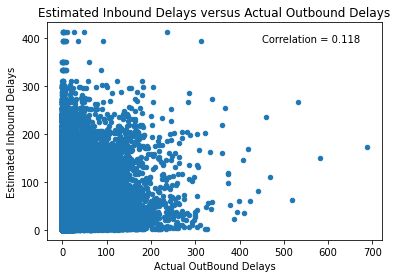

Text(0.5, 1.0, 'Estimated Inbound Delays versus Actual Outbound Delays')

In [0]:
plot_df = df.filter("YEAR = 2016").groupBy(*["DEST_AIRPORT_ID", "MONTH", "DAY_OF_MONTH"])\
    .agg(sum("DEP_DEL15").alias("Actual OutBound Delays"), avg('estimated_inbound_delays').alias("Estimated Inbound Delays"))
pd_df = plot_df.toPandas()
ax = pd_df.plot.scatter(x="Actual OutBound Delays", y="Estimated Inbound Delays")
cor = np.round(pd_df.corr().loc["Actual OutBound Delays", 'Estimated Inbound Delays'], 3)
plt.text(450, 390, f"Correlation = {cor}")
plt.title("Estimated Inbound Delays versus Actual Outbound Delays")

Next, we directly compare our outcome variable, delayed flights, to the estimated inbound delayed flights with a boxplot. Again, we use the 2016 data subset. The relationship appears random, and the calculated correlation is 0.043. We theorize about PageRank's inefficacy and discuss alternative implementations in the conclusion.

Out[2475]:

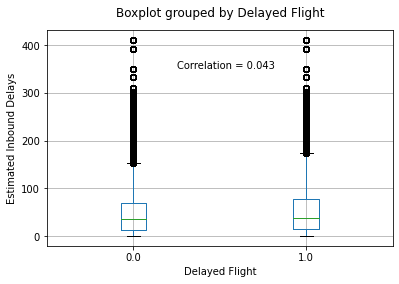

Text(1.25, 350, 'Correlation = 0.043')

In [0]:
# plot_df = df.filter("YEAR = 2016 and DEST_AIRPORT_ID = 10397").toPandas()
# plot_df["Delayed Flight"] = plot_df.loc[:, "DEP_DEL15"]
# ax= plot_df.boxplot(column="estimated_inbound_delays", by="Delayed Flight")
# ax.set_xlabel("Delayed Flight")
# ax.set_ylabel("Estimated Inbound Delays")
# plt.title("")
plot_df = df.filter("YEAR = 2016").select(*['DEP_DEL15', "estimated_inbound_delays" ]).toPandas()
cor = np.round(plot_df.corr().loc["DEP_DEL15", "estimated_inbound_delays"], 3)
plot_df["Delayed Flight"] = plot_df.loc[:, "DEP_DEL15"]
ax= plot_df.boxplot(column="estimated_inbound_delays", by="Delayed Flight")
ax.set_xlabel("Delayed Flight")
ax.set_ylabel("Estimated Inbound Delays")
plt.title("")
cor = np.round(plot_df.corr().loc["DEP_DEL15", "estimated_inbound_delays"], 3)
plt.text(1.25, 350, f"Correlation = {cor}")

### Feature Transformations
We apply several transformations to increase the data's compatibility with supervised models. We apply one hot encoding to categorical variables. Null values are filled with feature means for all *numeric* variables. PySpark's imputer does not guarantee accurate imputation of categorical variables. Therefore, rows with null categorical values are dropped from the data. In the following cell, our variables are listed by type. Finally, we apply a standard scaler to all features.

All imputation and scaling is based on the 2015 data. In initial attempts at one hot encoded, we noted that certain categorical variables not present in the training set were dropped by the encoder on the validation and test sets. For example, the `YEAR` variable only took the value 2015 in the train set, and all future years were lost. To accomodate this issue, synthetic rows are created which contain all values of categorical variables in the full dataset. These rows are passed to the encoder to allow encoding of categorical values not present in the train set. The synthetic rows are then dropped from the dataset. 

The `create_scaled_features()` function below performs all of the encoding, imputation, and scaling.

In [0]:
# List all the categorical variables (i.e., non-numeric)
categorical_variables = ['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
                         "DEP_HOUR_OF_UTC", 'OP_CARRIER_AIRLINE_ID', "DEST_AIRPORT_ID", "ORIGIN_AIRPORT_ID", 
                         'DEST_STATE_FIPS', "DISTANCE_GROUP"]

# List all the numeric variables (i.e., non-categorical)
numeric_variables = ["WND_ANGLE", "WND_SPEED", "CIG_DIM", "VIS_DIST",
                     "TMP_AIR", "DEW_POINT", "SLP_DAY", "lon",
                     "lat", 'neighbor_lon', 'neighbor_lat', "DISTANCE",
                     "DIV_AIRPORT_LANDINGS", "distance_to_neighbor", "lag_del_by_day", "historical_pagerank",
                     "estimated_inbound_delays"]

# List all the columns to be dropped/removed from the dataset
drop_cols = ["ORIGIN_WAC", "DEST_WAC", "FLIGHTS", "OP_CARRIER_FL_NUM", "MONTH_OBS",
             "YEAR_OBS", "FLIGHT_HOUR_OBS", "DEP_TIME", "DEP_HOUR_OF", "DEST_AIRPORT_SEQ_ID",
             "ORIGIN_AIRPORT_SEQ_ID", "pagerank", "hist_pr_id", "pr_id"]

# Set the columns to keep during the scaling we perform next
keep_cols = ["id", "DEP_DEL15", "DEP_DELAY_NEW", "YEAR"]

# Define the users to use during the transformation
transform_years = [2016, 2017, 2018, 2019]

In [0]:
# Scale all of our features to allow for better analysis
transformed_data = create_scaled_features(data=df, train_year=2015,
                       transform_years=transform_years,
                       keep_cols=keep_cols,
                       categorical_variables=categorical_variables,
                       numeric_variables=numeric_variables,
                       drop_variables=drop_cols,
                       write=True)

Transformed data count is 31746841

Categorical feature encoding generates a 923 column feature vector. Over 600 of these features come from the encoding of `DEST_AIRPORT_ID` and `ORIGIN_AIRPORT_ID` which are unique identifiers for specific airports. Initial tests of the 923 column vector indicated training time would be prohibitive on expensive models such as random forest. We apply Principal Component Analysis to compress the dataset to the top 100 principal components which explain 99.98% of the original variance. However, model explainability is hindered by this transformation.

In [0]:
# Apply PCA and write the result back to azure data lake storage
pca = PCA(k=100, inputCol="scaledFeatures")
pca.setOutputCol("pcaFeatures")
model_pca = pca.fit(transformed_data.filter('YEAR < 2019'))
pca_data = model_model.transform(transformed_data).select(*['DEP_DEL15', 'DEP_DELAY_NEW', "YEAR", "pcaFeatures"])
pca_data.write.mode('overwrite').parquet(f"{blob_url}/feature-engineering/pca-data")

In [0]:
model_pca.explainedVariance.sum()

Out[1476]: 0.9997849694242401

### Create Train and Test Sets for ML Pipeline

We now split datasets based on `YEAR`. During this process, because the data is unbalanced (most of flights do not delay), we perform random oversampling in the minority class (flights delayed) aiming to get to a 50-50% class balance in the training dataset. The oversampling is performed in `get_split_data()` and present in the returned training dataframes. Note, we do not over sample the test sets.

In [0]:
# Split train/test for baseline
train_df, test_df = get_split_data(flights_weather_data, env=STAGE, write=write_flag)
# return the number of folds for cross validation evaluations
nFolds = count_folds(flights_weather_data)

Your new df_train has 39,289,372 rows.
Your new df_test has 7,422,037 rows.
Year, fold_number mapping: {2018: 3, 2015: 0, 2019: 4, 2016: 1, 2017: 2}

In `get_cvdata()`, a `foldCol` is created which specifies how we want to fold the data for cross-validation.

In [0]:
foldedTrainDF, foldedTestDF = get_cvdata(train_df, test_df, env='prod', features='dev', write=write_flag)

Your new training set has 38,002,813 rows.
Your new test set has 7,046,171 rows.

In [0]:
# Split train/test for Feature Engineered model 
pca_data = spark.read.parquet(f"{blob_url}/feature-engineering/pca-data").cache()
train_df_fe, test_df_fe = get_split_data(pca_data, env="prod", write=write_flag) #fe for feature engineered

Your new df_train has 39,289,372 rows.
Your new df_test has 7,422,037 rows.

In [0]:
foldedTrainDF_fe, foldedTestDF_fe = get_cvdata(train_df_fe, test_df_fe, env='prod', features='prod', write=write_flag)

Year, fold_number mapping: {2018: 3, 2015: 0, 2016: 1, 2017: 2}
Total number of folds: 3
Your new training set has 39,289,372 rows.
Your new test set has 7,291,927 rows.

## 6. Algorithm Exploration
The primary algorithms we explored in this project were logistic regression, decision tree, random forest, multilayer perceptron and linear regression. 
##### Classifications <br>
Here we use the binary column DEP_DEL15 for our outcome variable, "0" for not delayed for 15+ minutes and "1" for cases where its delayed by 15+ minutes. 

##### Regressions <br>
Here, we predict on the outcome variable DEP_DELAY_NEW which is a continuous variable containing positive values.

## 7. Algorithm Implementation & Evaluation
Each model we test is run on a first on baseline data with basic data processing done to extract from the columns and vector assembly for data to be properly formatted. Based on their performance, they then trained and tested on a dataset with more feature engineering including one hot encoding, a pagerank feature column, and then run in an assembly vector. Because our problem deals with a benefit that we don't want to over-provide - and so don't want many false positive cases, we want to primarily optimize for precision. Additionally, we report accuracy and F-meaures to illustrate performance and handle the fact that our data is in fact imbalanced, as we found in the delayed to not delayed ratio of 4.5:1. For example, for logistic and linear regression, we employ the cross validation to discover the model that optimizes for precision and mean squared error, respectively. 

##### Method: Cross-validation on a rolling basis
For all algorithms, we start with a small subset of data for training purpose, forecast for the later data points and then checking the accuracy for the forecasted data points. The same forecasted data points are then included as part of the next training dataset and subsequent data points are forecasted.

- Logistic Regression <br>
In logistic regression, we attempt to model a binary response where the output function is described by the equation
$$
f(z) = \frac{1}{1+e^{-z}}
$$
In this context, we expect an output of either a 0 or 1, well fitting to our classification problem predicting delayed or not delayed. Here, we use cross validation to tune for `elasticNetParam`  as well as `regParam`. In particular, by tuning `elasticNetParam` we fluctuate between a Ridge at 0 and a Lasso Regression model at 1.

#### Logistic Regression Baseline

In [0]:
## Import all the functions for running our models below
%run ./model_functions

In [0]:
lr = LogisticRegression(featuresCol = 'features', labelCol = label_cat, maxIter=10, regParam=0.3, elasticNetParam=0.8)
# build the parameter grid for model tuning
lr_paramGrid = ParamGridBuilder() \
          .addGrid(lr.regParam, [0.01, 0.1]) \
          .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
          .build()

# execute TimeSeriesCrossValidator for model tuning
lr_crossval = TimeSeriesCrossValidator(estimator=lr,
                          estimatorParamMaps=lr_paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol=label_cat, 
                                                                  metricName='areaUnderROC'),
                          parallelism=3,
                          foldCol='foldCol',
                          numFolds=nFolds)

# train the tuned model and establish our best model
lr_cvModel = lr_crossval.fit(foldedTrainDF)
lr_model_baseline = lr_cvModel.bestModel

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
display(foldedTrainDF)

DEP_DEL15,DEP_DELAY_NEW,features,foldCol
0.0,0.0,"Map(vectorType -> dense, length -> 37, values -> List(1.0, 2.0, 1.0, 7.0, 19393.0, 1743.0, 11481.0, 1148102.0, 33.0, 10693.0, 1069302.0, 47.0, 54.0, 1531.0, 1.0, 401.0, 2.0, 0.0, 15.0, 20.0, 30.349, -85.788, 30.349, -85.788, 0.0, 2015.0, 2.0, 20.0, 145.0, 36.0, 487.5, 5633.0, 118.5, 103.0, 10165.0, 2015.0, 5.41165884289E11))",0
0.0,0.0,"Map(vectorType -> dense, length -> 37, values -> List(1.0, 3.0, 10.0, 2.0, 19393.0, 320.0, 11481.0, 1148102.0, 33.0, 10693.0, 1069302.0, 47.0, 54.0, 1916.0, 1.0, 401.0, 2.0, 0.0, 19.0, 23.0, 30.349, -85.788, 30.349, -85.788, 0.0, 2015.0, 3.0, 23.0, 206.66666666666666, 51.333333333333336, 7536.666666666667, 16093.0, 215.66666666666666, 143.33333333333334, 10163.666666666666, 2015.0, 5.4116588429E11))",0
0.0,0.0,"Map(vectorType -> dense, length -> 37, values -> List(1.0, 3.0, 18.0, 3.0, 19790.0, 1799.0, 11481.0, 1148102.0, 33.0, 10397.0, 1039705.0, 13.0, 34.0, 552.0, 1.0, 240.0, 1.0, 0.0, 5.0, 9.0, 30.349, -85.788, 30.349, -85.788, 0.0, 2015.0, 3.0, 9.0, 165.0, 13.0, 12067.0, 16093.0, 47.0, 62.5, 10135.0, 2015.0, 5.41165884291E11))",0
0.0,0.0,"Map(vectorType -> dense, length -> 37, values -> List(1.0, 3.0, 29.0, 7.0, 19393.0, 350.0, 11481.0, 1148102.0, 33.0, 10693.0, 1069302.0, 47.0, 54.0, 800.0, 1.0, 401.0, 2.0, 0.0, 8.0, 12.0, 30.349, -85.788, 30.349, -85.788, 0.0, 2015.0, 3.0, 12.0, 190.0, 21.0, 3048.0, 16093.0, 89.0, 61.0, 10251.0, 2015.0, 5.41165884292E11))",0
0.0,0.0,"Map(vectorType -> dense, length -> 37, values -> List(2.0, 4.0, 4.0, 6.0, 20366.0, 5266.0, 11481.0, 1148102.0, 33.0, 10397.0, 1039705.0, 13.0, 34.0, 1550.0, 1.0, 240.0, 1.0, 0.0, 15.0, 19.0, 30.349, -85.788, 30.349, -85.788, 0.0, 2015.0, 4.0, 19.0, 200.0, 93.0, 22000.0, 16093.0, 183.0, 67.0, 10245.0, 2015.0, 5.41165884293E11))",0
0.0,4.0,"Map(vectorType -> dense, length -> 37, values -> List(2.0, 4.0, 12.0, 7.0, 19790.0, 1403.0, 11481.0, 1148102.0, 33.0, 10397.0, 1039705.0, 13.0, 34.0, 1719.0, 1.0, 240.0, 1.0, 0.0, 17.0, 21.0, 30.349, -85.788, 30.349, -85.788, 0.0, 2015.0, 4.0, 21.0, 150.0, 62.0, 1524.0, 16093.0, 267.0, 150.0, 10140.0, 2015.0, 5.41165884294E11))",0
0.0,0.0,"Map(vectorType -> dense, length -> 37, values -> List(2.0, 4.0, 13.0, 1.0, 19790.0, 2506.0, 11481.0, 1148102.0, 33.0, 10397.0, 1039705.0, 13.0, 34.0, 1431.0, 1.0, 240.0, 1.0, 0.0, 14.0, 18.0, 30.349, -85.788, 30.349, -85.788, 0.0, 2015.0, 4.0, 18.0, 65.0, 31.0, 11045.5, 10460.5, 186.0, 178.0, 10169.0, 2015.0, 5.41165884295E11))",0
0.0,0.0,"Map(vectorType -> dense, length -> 37, values -> List(2.0, 4.0, 13.0, 1.0, 20366.0, 4472.0, 11481.0, 1148102.0, 33.0, 12266.0, 1226603.0, 48.0, 74.0, 1413.0, 1.0, 572.0, 3.0, 0.0, 14.0, 18.0, 30.349, -85.788, 30.349, -85.788, 0.0, 2015.0, 4.0, 18.0, 65.0, 31.0, 11045.5, 10460.5, 186.0, 178.0, 10169.0, 2015.0, 5.41165884296E11))",0
0.0,0.0,"Map(vectorType -> dense, length -> 37, values -> List(2.0, 4.0, 13.0, 1.0, 19790.0, 1403.0, 11481.0, 1148102.0, 33.0, 10397.0, 1039705.0, 13.0, 34.0, 1713.0, 1.0, 240.0, 1.0, 0.0, 17.0, 21.0, 30.349, -85.788, 30.349, -85.788, 0.0, 2015.0, 4.0, 21.0, 200.0, 33.5, 883.5, 10460.5, 183.0, 150.0, 10168.5, 2015.0, 5.41165884298E11))",0
0.0,0.0,"Map(vectorType -> dense, length -> 37, values -> List(2.0, 5.0, 26.0, 2.0, 20366.0, 4579.0, 11481.0, 1148102.0, 33.0, 12266.0, 1226603.0, 48.0, 74.0, 606.0, 1.0, 572.0, 3.0, 0.0, 6.0, 10.0, 30.349, -85.788, 30.349, -85.788, 0.0, 2015.0, 5.0, 10.0, 240.0, 15.0, 457.0, 9656.0, 156.0, 117.0, 10141.0, 2015.0, 5.411658843E11))",0


In [0]:
trainingSummary = lr_model_baseline.summary
accuracy = trainingSummary.accuracy
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
print("Accuracy: %s\nF-measure: %s\nPrecision: %s"
    % (accuracy, fMeasure, precision))

Accuracy: 0.6251867460442994
F-measure: 0.6243243441820914
Precision: 0.6261595146740029

In [0]:
# Evaluation Metrics
predictions = lr_model_baseline.transform(foldedTestDF)
eval_ = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='DEP_DEL15')

# store performance metrics in a dictionary
metrics = ['accuracy', 'weightedPrecision', 'weightedRecall', 'weightedFMeasure']
results = {}
for m in metrics:
  if m in ['precisionByLabel', 'recallByLabel', 'fMeasureByLabel']:
    results[m] = [eval_.evaluate(predictions, {eval_.metricName: m, eval_.metricLabel:0.0}), 
                  eval_.evaluate(predictions, {eval_.metricName: m, eval_.metricLabel:1.0})]
  else:
    results[m] = eval_.evaluate(predictions, {eval_.metricName: m})
    
# print results
print('Performance metrics')
print('------------------------------------------------------------------------------------------------')
for x in results:
  print(f'{x}: {results[x]}')

Performance metrics
------------------------------------------------------------------------------------------------
accuracy: 0.5935183804083097
weightedPrecision: 0.7673605646460752
weightedRecall: 0.5935183804083097
weightedFMeasure: 0.6381340294773385

#### Logistic Regression with Feature Engineering

In [0]:
lr_model = get_logistic_regression(foldedTrainDF_fe, features='prod')
lr = LogisticRegression(featuresCol = 'features', labelCol = label_cat, maxIter=10, regParam=0.3, elasticNetParam=0.8)
# build the parameter grid for model tuning
lr_paramGrid = ParamGridBuilder() \
          .addGrid(lr.regParam, [0.01, 0.1]) \
          .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
          .build()

# execute TimeSeriesCrossValidator for model tuning
lr_crossval = TimeSeriesCrossValidator(estimator=lr,
                          estimatorParamMaps=lr_paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol=label_cat, 
                                                                  metricName='areaUnderROC'),
                          parallelism=3,
                          foldCol='foldCol',
                          numFolds=nFolds)

# train the tuned model and establish our best model
lr_cvModel = lr_crossval.fit(foldedTrainDF)
lr_model_baseline = lr_cvModel.bestModel

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
# Evaulation Metrics 
# Transform pipeline - https://spark.apache.org/docs/latest/ml-pipeline.html

predictions = lr_model.transform(foldedTestDF_fe)
eval_ = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='DEP_DEL15')

# store performance metrics in a dictionary
metrics = ['accuracy', 'weightedPrecision', 'weightedRecall', 'weightedFMeasure']
results = {}
for m in metrics:
  if m in ['precisionByLabel', 'recallByLabel', 'fMeasureByLabel']:
    results[m] = [eval_.evaluate(predictions, {eval_.metricName: m, eval_.metricLabel:0.0}), 
                  eval_.evaluate(predictions, {eval_.metricName: m, eval_.metricLabel:1.0})]
  else:
    results[m] = eval_.evaluate(predictions, {eval_.metricName: m})
    
# print results
print('Performance metrics')
print('------------------------------------------------------------------------------------------------')
for x in results:
  print(f'{x}: {results[x]}')
    

Performance metrics
------------------------------------------------------------------------------------------------
accuracy: 0.48397261793761787
weightedPrecision: 0.7200848725242478
weightedRecall: 0.48397261793761787
weightedFMeasure: 0.5360222265211196

#### Decision Tree <br>
Our classification method is based on Gini impurity. Node impurity is a function of the frequency of the label i at a particular node where C is the count of unique labels. 
$$
\sum_{i=1}^{C}f_i(1-f_i)
$$
Here, we use our cross validation to tune for `maxBins` and `maxDepth` where `maxBins` refers to how many split candidates use used in decision making while `maxDepth` refers to the node depth of the decision tree.

##### Decision Tree Baseline

In [0]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol= label_cat)

# build the parameter grid for model tuning
dt_paramGrid = ParamGridBuilder() \
               .addGrid(dt.maxBins, [10, 20, 40, 80]) \
               .addGrid(dt.maxDepth, [2, 4, 8]) \
               .build()

# execute TimeSeriesCrossValidator for model tuning
dt_crossval = TimeSeriesCrossValidator(estimator=dt,
                          estimatorParamMaps=dt_paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='DEP_DEL15', 
                                                                  metricName='areaUnderROC'),
                          parallelism=3,
                          foldCol='foldCol',
                          numFolds=nFolds)

In [0]:
dt_cvModel = dt_crossval.fit(foldedTrainDF)
dt_model = dt_cvModel.bestModel

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
predictions_dt = dt_model.transform(foldedTestDF)
decisiontree_perf_summary(predictions_dt)

Performance metrics
------------------------------------------------------------------------------------------------
accuracy: 0.549991477640835
weightedPrecision: 0.7757178136013948
weightedRecall: 0.549991477640835
weightedFMeasure: 0.5966627691893385

##### Decision Tree Feature Engineered

Now that we have our baseline Decision Tree model we will construct a second one using all of our feature engineered variables. This will allow us to see if we can improve upon our baseline model's results.

In [0]:
# https://spark.apache.org/docs/1.5.2/ml-decision-tree.html
dt_fe = DecisionTreeClassifier(featuresCol = 'pcaFeatures', labelCol= label_cat)

# build the parameter grid for model tuning
dtfe_paramGrid = ParamGridBuilder() \
               .addGrid(dt_fe.maxBins, [10, 20, 40, 80]) \
               .addGrid(dt_fe.maxDepth, [2, 4, 8]) \
               .build()

# execute TimeSeriesCrossValidator for model tuning
dtfe_crossval = TimeSeriesCrossValidator(estimator=dt_fe,
                          estimatorParamMaps=dtfe_paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='DEP_DEL15', 
                                                                  metricName='areaUnderROC'),
                          parallelism=3,
                          foldCol='foldCol',
                          numFolds=nFolds)

In [0]:
dtfe_cvModel = dtfe_crossval.fit(foldedTrainDF_fe)
dtfe_model = dtfe_cvModel.bestModel

# dt_Model = dt.fit(foldedTrainDF)

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
# Evaluation Metrics
predictions_dtfe = dt_Model_fe.transform(foldedTestDF_fe)
decisiontree_perf_summary(predictions_dtfe)

Performance metrics
------------------------------------------------------------------------------------------------
accuracy: 0.5009653826759374
weightedPrecision: 0.7392799139895636
weightedRecall: 0.5009653826759374
weightedFMeasure: 0.5512227892323165

#### Random Forest <br>
Our Random Forest, an ensemble of decision trees, was developed similar to our decision tree where our classifcation method is again based on Gini impurity.

##### Random Forest Baseline

In [0]:
rfw = RandomForestClassifier(featuresCol='pcaFeatures', labelCol='DEP_DEL15', numTrees = 500, featureSubsetStrategy='sqrt', 
                             maxDepth=6, impurity='gini', seed=123)

# build the parameter grid for model tuning
rfw_paramGrid = ParamGridBuilder() \
               .addGrid(rfw.numTrees, [100, 500]) \
               .addGrid(rfw.maxDepth, [4, 8]) \
               .build()

# execute TimeSeriesCrossValidator for model tuning
rfw_crossval = TimeSeriesCrossValidator(estimator=rfw,
                          estimatorParamMaps=rfw_paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='DEP_DEL15', 
                                                                  metricName='areaUnderROC'),
                          parallelism=3,
                          foldCol='foldCol',
                          numFolds=nFolds)

In [0]:
rfw_cvModel = rfw_crossval.fit(foldedTrainDF_fe)
rfw_model = rfw_cvModel.bestModel

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
rfw_model

Out[1795]: RandomForestClassificationModel: uid=RandomForestClassifier_af7da267a9ec, numTrees=500, numClasses=2, numFeatures=100

In [0]:
# print best model params
print(f'Best Param (numTrees): {rfw_model.getNumTrees}')
print(f'Best Param (maxDepth): {rfw_model.getMaxDepth()}')
print(f'Best Param (featureSubsetStrategy): {rfw_model.getFeatureSubsetStrategy()}')

Best Param (numTrees): 500
Best Param (maxDepth): 8
Best Param (featureSubsetStrategy): sqrt

In [0]:
# Evaluation Metrics
predictions = rfw_model.transform(foldedTrainDF_fe)
eval_ = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='DEP_DEL15')

# store performance metrics in a dictionary
metrics = ['accuracy', 'weightedPrecision', 'weightedRecall', 'weightedFMeasure']
results = {}
for m in metrics:
  if m in ['precisionByLabel', 'recallByLabel', 'fMeasureByLabel']:
    results[m] = [eval_.evaluate(predictions, {eval_.metricName: m, eval_.metricLabel:0.0}), 
                  eval_.evaluate(predictions, {eval_.metricName: m, eval_.metricLabel:1.0})]
  else:
    results[m] = eval_.evaluate(predictions, {eval_.metricName: m})

# print results
print('Performance metrics')
print('------------------------------------------------------------------------------------------------')
for x in results:
  print(f'{x}: {results[x]}')


Performance metrics - TRAINING SET
------------------------------------------------------------------------------------------------
accuracy: 0.6098003297176651
weightedPrecision: 0.6098038626759932
weightedRecall: 0.6098003297176651
weightedFMeasure: 0.6097969416517437
precisionByLabel: [0.6091963201885542, 0.6104115013526361]
recallByLabel: [0.6127383350331496, 0.606861859242297]
fMeasureByLabel: [0.610962194001986, 0.6086315048128468]

##### Linear Regression Baseline

In this section, we will be using a linear regression model to see how well it will predict the delay time of a given flight. First, we will construct a baseline model to that end. Here, we employ linear regression where our loss function is squared loss:
$$
f(z) = \frac{1}{2}(w^{T}x-y)^2
$$
As with the logistic regression, we will be tuning `elasticNetParam` as well as `regParam` where `elasticNetParam` fluctuates between a Ridge at 0 and a Lasso Regression model at 1.

In [0]:
# trains model with cross validation and returns the model with the best performance
lnr = LinearRegression(featuresCol = 'features', labelCol = label_cont, maxIter=10, regParam=0.3, elasticNetParam=0.8)
# build the parameter grid for model tuning
lnr_paramGrid = ParamGridBuilder() \
          .addGrid(lnr.regParam, [0.01, 0.1]) \
          .addGrid(lnr.elasticNetParam, [0.0, 0.5, 1.0]) \
          .build()

# execute TimeSeriesCrossValidator for model tuning
lnr_crossval = TimeSeriesCrossValidator(estimator=lnr,
                          estimatorParamMaps=lnr_paramGrid,
                          evaluator=RegressionEvaluator(labelCol=label_cont, 
                                                              metricName='r2'), 
                          parallelism=3,
                          foldCol='foldCol',
                          numFolds=nFolds)

# train the tuned model and establish our best model
lnr_cvModel = lnr_crossval.fit(foldedTrainDF)
linear_model_baseline = lnr_cvModel.bestModel

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
# testing # Print the performance of our model
trainingSummary = linear_model_baseline.summary

print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 60.525519
r2: 0.042824

In [0]:
# Calculate the adjusted R^2 value
r2 = trainingSummary.r2
n = foldedTrainDF.count()
p = len(foldedTrainDF.columns)
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print("adjusted_r2: %f" % adjusted_r2)

adjusted_r2: 0.042832

##### Linear Regression Feature Engineered

Now, we will incorporate our feature engineered data into a linear regression to see if we can outperform our baseline linear regression model.

In [0]:
# Instantiate a linear regression model
linear_model_fe = LinearRegression(featuresCol = 'pcaFeatures', labelCol= label_cont, maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Build the parameter grid for model tuning
lnr_paramGrid = ParamGridBuilder() \
              .addGrid(linear_model_fe.regParam, [0.01, 0.1]) \
              .addGrid(linear_model_fe.elasticNetParam, [0.0, 0.5, 1.0]) \
              .build()

# Execute TimeSeriesCrossValidator for model tuning
lnr_crossval_fe = TimeSeriesCrossValidator(estimator=linear_model_fe,
                          estimatorParamMaps=lnr_paramGrid,
                          evaluator=RegressionEvaluator(labelCol=label_cont),
                          parallelism=3,
                          foldCol='foldCol',
                          numFolds=nFolds)

In [0]:
# Cross validate our models and pick the best one
lnr_cvModel = lnr_crossval_fe.fit(foldedTrainDF_fe)
lnr_model_fe = lnr_cvModel.bestModel

MLlib will automatically track trials in MLflow. After your tuning fit() call has completed, view the MLflow UI to see logged runs.

In [0]:
## Print out the RMSE and R^2 values for this model
trainingSummary = lnr_model_fe.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 62.538187
r2: 0.005451

In [0]:
## Calculate the adjusted R^2 value for this model
r2 = trainingSummary.r2
n = foldedTrainDF.count()
p = len(foldedTrainDF.columns)
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print("adjusted_r2: %f" % adjusted_r2)

adjusted_r2: 0.005451

- Multilayer Perceptron <br>
For our multilayer perceptron, we attempt to classify with an artificial neural network where our activation function uses the sigmoid or logistic function in its intermediate layers.
$$
f(z_i) = \frac{1}{1+e^{-z_i}}
$$

##### Multilayer Perceptron Baseline

In [0]:
# Set the layers 
layers = [len(feature_cols)+1, 5, 4, 2]
trainer = MultilayerPerceptronClassifier(featuresCol = 'features', labelCol= label_cat, maxIter=10, layers=layers, blockSize=128, seed=1234)

In [0]:
# Fit the model using the folded data
model = trainer.fit(foldedTrainDF)

In [0]:
# Run a prediction using the new model
model.predict(foldedTestDF.head().features)

Out[3465]: 1.0

In [0]:
# Determine the test accuracy of the newly created perceptron model
result = model.transform(foldedTestDF)
predictionAndLabels = result.select("prediction", label_cat)
evaluator = MulticlassClassificationEvaluator(labelCol= label_cat, metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

Test set accuracy = 0.18886470396474908

After running our Perceptron model, we were only able to achieve a test set accuracy of around ~19%. There may be some tweaking we could do in the future to improve upon this, but for now it seems that this will not be our best model.

## 8. Conclusions

After exploring the data, architecting an end-to-end data pipeline, and implementing several different models, below is a summary of our results across our different models:

#### Classification models
| Model                               | Accuracy     | Weighted F-measure   | Weighted Precision   | Weighted Recall  |
| -----------                         | -----------  | -----------          | -----------          | -----------      |
| **Logistic Regression (Baseline)**  | **0.594**    | **0.638**            | **0.767**            | **0.594**        |
| Logistic Regression w/ Feature Eng. | 0.484        | 0.536                | 0.720                | 0.484            |
| Random Forest                       | 0.610        | 0.610                | 0.610                | 0.610            |
| Decision Tree (Baseline)            | 0.550        | 0.600                | 0.776                | 0.550            |
| Decision Tree w/ Feature Eng.       | 0.501        | 0.551                | 0.739                | 0.501            |
| Perceptron                          | 0.188        | -                    | -                    | -                |

#### Continuous models
| Model                               | RMSE        | R^2         | Adjusted R^2  | 
| -----------                         | ----------- | ----------- | -----------   |
| **Linear Regression (Baseline)**    | **60.48**   | **0.0431**  | **0.0428**    | 
| Linear Regression w/ Feature Eng.   | 62.54       | 0.00545     | 0.00545       |

From these results, we can see that we were not able to exceed our baseline models through our feature engineering efforts. Due to the fact that we are optimizing on an imbalanced dataset we are therefore optimizing for our F-measure. Here, we find that our Logistic Regression (Baseline) model was the optimal with a weighted F-measure of 63.8% and weighted precision of 76.7%. On the other hand, our least performant model in terms of weighted F-measure was our Logistic Regression with additional feature engineering where the weighted F-measure of 53.6% (though its weighted precision was 72%). In terms of accuracy, the Perceptron model was the least performant of only 18.8%.  

In terms of our linear regression models, once again, our baseline model outperformed the feature engineered model. In the end, our Linear Regression (Baseline) model outperformed with an RMSE of 60.48%. Once again, we would need to revisit our feature engineering to better understand what we could do to improve from our baseline. In practice, this baseline model would be the one we use for our food voucher program.

Interestingly, for most of our models, the addition of feature engineered variables did not end up improving our results. Included in this were our PageRank features though we do not know the direct impact of these features alone. As it is not immediately clear, we expect understanding this further may require more investigation (see the section below). In the future we may want to split up our feature engineering steps into several different models in such a way that we can quantify the impact of each change in iteration.

The majority of our models hovered between 0.5 - 0.6 accuracy, 0.53 - 0.61 for weighted f-measure, 0.73 - 0.77 for weighted, and 0.55 - 0.6 for weighted recall. In general, these ranges appear to be fairly narrow. This may mean that perhaps we need to explore additional model configurations in order to derive substantial differentation between these.

As it relates to our business case, we can now use this model to determine the value of the voucher to provide to our clients. More specifically, as our initial business case outlined, we are not only interested in predicting if a flight is delayed, but by how much (using our linear regression model). So, with that in mind, we will: (1) distribute a voucher to our clients who are expected to be subject to a flight delay within the next 2 hours, and (2) determine the amount of the voucher according to the predicted amount of delay. Part (1) will be determined using our logistic regression model, and part (2) will be determined according to the predicted delay from our linear regression model. These vouchers will be dispensed through our associated mobile app, directly to the user's phone, as a redeemable code/barcode. In this fashion, we hope to ensure the highest caliber of customer satisfication to our clients.

#### Next Steps

For any subsequent attempts to improve upon this project's work, below are a compiled list of techniques that we would like to implement (in no particular order):
- Support Vector Machine (SVM) application
- Winnow classifier implementation
- Apply Dijkstra's Algorithm to flight paths and include as a feature
- Work on a higher match-rate for joining datasets
- Break-down our feature engineering into a more 'step-by-step' approach such that we might understand better which parts are effective, and which are not.
- Implement PageRank in a different way (see section below)
- Experiment with rank encoding for certain categorical features

#### PageRank Alternatives and Alterations
Our PageRank implementation provided little unique information to our supervised models. Are flight delays not a function of the graph they are apart of or did our PageRank implementation fail to capture network effects that do exist? To answer the first question, we might evaluate rather an individual plane's delay gets propogated to its next scheduled flight. We might also analyze rather accumulated delays at the airline carrier level are propogated across the carrier's scheduled flights. However, flights do form a graph, and we believe it's more likely that our PageRank implementation failed to capture network effects than that network effects do not exist.

Alternative implementations of PageRank may prove more informative. First, we multiply the PageRank probability distribution by the number of delays in the system with a one day lag. This calculation of delayed flights might be too coarse to capture an effect. Most flights within the United States are less than six hours. If a delay occurs, airports and airlines likely take action to mitigate that delay's ability to propogate through their networks, and whatever signal our PageRank implementation may have captured is lost. We might observe better results by  applying the PageRank probability distribution to a tighter window of time.

In addition, our stochastic matrix is formed with columns as a percentage of outbound delayed flights from a source airport to a destination airport. This could be reformulated so that each column is the percentage of delayed inbound flights for a given airport. With this formulation, the Pagerank probability distribution becomes the probability that a random delayed flight is inbound to an airport. This alternative formulation might prove superior by ranking inbound delays rather than outbound delays.

## 9. Application of Course Concepts

Over the course of this project, we utilized many skills that we gained from the teachings of this course. Without said skills, this project would not have been possible.

Here is a non-exhaustive list of the skills we applied throughout this project:

- We used a cluster setup to import our data in the form of Spark dataframes.
- We implemented n-fold cross validation.
- We read and wrote our files in a parquet format since it is memory efficient and enables faster processing.
- We implemeneted Pagerank on the flights dataset and included it as a feature for our training.
- We scaled our features such that they are more comparable to one another
- We used one-hot encoding for our categorical variables, where applicable
- We employed linear regression, logistic regression, a perceptron model, a decision tree model, and a random forest model using Spark's built-in ML library functions.
- We utilized MapReduce concepts in our implementations.

#### Citations
1. “FAQ: Weather Delay.” FAQ: Weather Delay, 11 Mar. 2021, https://www.faa.gov/nextgen/programs/weather/faq/. 
2. "OST_R | BTS | Transtats.", 11 Mar. 2021, https://transtats.bts.gov/Homepage.asp. 
3. DOC/NOAA/NESDIS/NCDC; National Climatic Data Center, NESDIS. “Quality Controlled Local Climatological Data (QCLCD) Publication.” National Centers for Environmental Information (NCEI), NOAA National Centers for Environmental Information (NCEI), 1 Jan. 1996, https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc%3AC00679.